In [162]:
# sytem lib
import os

# common lib
import numpy as np
import segmentation_models_pytorch as smp

# torh lib
import torch
from dotenv import load_dotenv
from sklearn.model_selection import train_test_split
from torch import nn
from torch.optim import Adam
from tqdm import tqdm

DATA_DIR = './dataset'

# determine the device to be used for training and evaluation
DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'
# determine if we will be pinning memory during data loading
PIN_MEMORY = True if DEVICE == 'cuda' else False

load_dotenv()

True

### Utilities

In [163]:
# helper function for data visualization
import matplotlib.pyplot as plt


def visualize(**images):
    """PLot images in one row."""
    n = len(images)
    plt.figure(figsize=(16, 5))
    for i, (name, image) in enumerate(images.items()):
        plt.subplot(1, n, i + 1)
        plt.xticks([])
        plt.yticks([])
        plt.title(' '.join(name.split('_')).title())
        plt.imshow(image)
    plt.show()

# 1. Data

## 1.1 Download data

In [164]:
from google_drive_downloader import GoogleDriveDownloader as gdd

FILE_ID = os.getenv('FILE_ID')

if not os.path.exists(DATA_DIR):
    print('Loading data...')
    os.makedirs(DATA_DIR)
    dest_path = os.path.join(DATA_DIR, 'dataset.zip')
    gdd.download_file_from_google_drive(
        file_id=FILE_ID,
        dest_path=dest_path,
        unzip=True,
    )
    print('Done!')

## 1.2 Define dataset

In [165]:
import cv2
from torch.utils.data import Dataset


class MedPatDataset(Dataset):
    def __init__(self, imagePaths, maskPaths, preprocessing, augmentation):
        # store the image and mask filepaths, and augmentation
        # transforms
        self.imagePaths = imagePaths
        self.maskPaths = maskPaths
        self.preprocessing = preprocessing
        self.augmentation = augmentation

    def __len__(self):
        # return the number of total samples contained in the dataset
        return len(self.imagePaths)

    def __getitem__(self, idx):
        # grab the image path from the current index
        imagePath = self.imagePaths[idx]
        # load the image from disk, swap its channels from BGR to RGB,
        # and read the associated mask from disk in grayscale mode
        image = cv2.imread(imagePath)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        mask = cv2.imread(self.maskPaths[idx], 0)
        class_label = float(np.sum(mask) > 0)
        mask = mask.reshape((mask.shape[0], mask.shape[1], 1))

        # check to see if we are applying any transformations
        if self.augmentation is not None:
            sample = self.augmentation(image=image, mask=mask)
            image, mask = sample['image'], sample['mask']
        # apply preprocessing
        if self.preprocessing:
            sample = self.preprocessing(image=image, mask=mask)
            image, mask = sample['image'], sample['mask']

        # return a tuple of the image and its mask
        return (image, mask, class_label)

## 1.3 Split to train and test

In [166]:
TEST_SPLIT = 0.2


def list_full_paths(directory):
    return [os.path.join(directory, file) for file in os.listdir(directory)]


imagePaths = list_full_paths(os.path.join(DATA_DIR, 'images'))
maskPaths = list_full_paths(os.path.join(DATA_DIR, 'masks'))

train_img, test_img, train_masks, test_masks = train_test_split(
    imagePaths, maskPaths, test_size=TEST_SPLIT, random_state=42
)
print(f'Train size = {len(train_img)}')
print(f'Test size = {len(test_img)}')


Train size = 160
Test size = 40


Image and mask for class 0.0


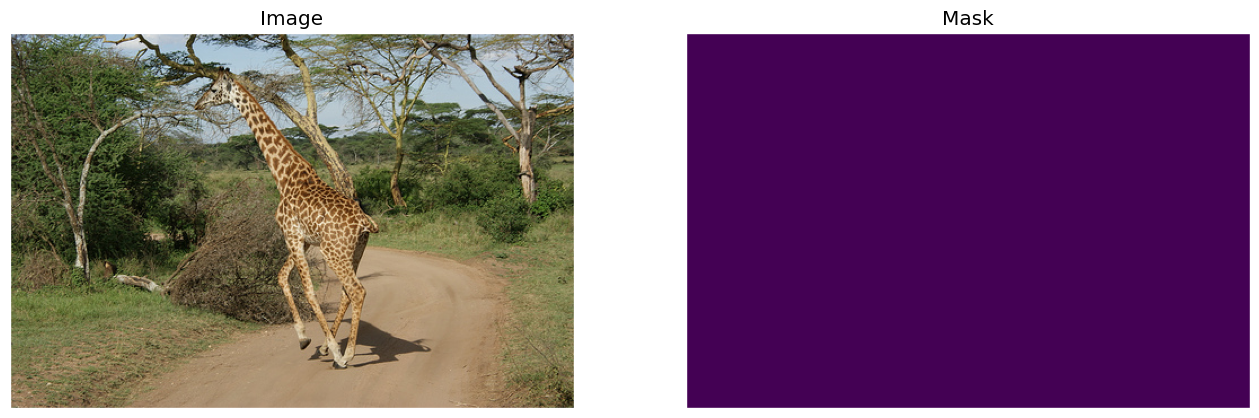

In [167]:
# just look on raw data
train_dataset = MedPatDataset(train_img, train_masks, None, None)
test_dataset = MedPatDataset(test_img, test_masks, None, None)

image, mask, class_label = train_dataset[1]  # get some sample
print(f'Image and mask for class {class_label}')
visualize(
    image=image,
    mask=mask.squeeze(),
)

Image and mask for class 1.0


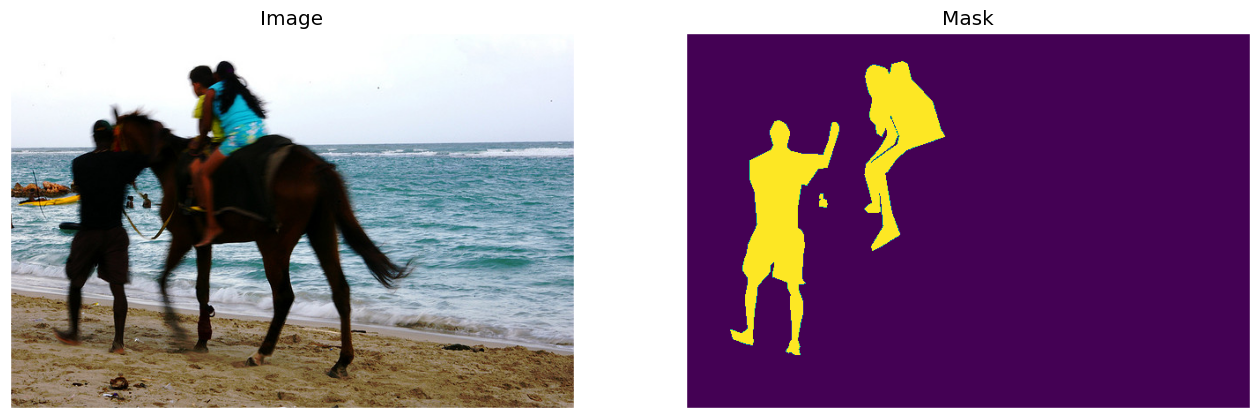

In [168]:
image, mask, class_label = train_dataset[10]  # get some sample
print(f'Image and mask for class {class_label}')
visualize(
    image=image,
    mask=mask.squeeze(),
)

## 1.4 Check class balance

In [169]:
train_class_1 = 0
for images, gt_masks, class_label in train_dataset:
    if class_label == 1:
        train_class_1 += 1
test_class_1 = 0
for images, gt_masks, class_label in test_dataset:
    if class_label == 1:
        test_class_1 += 1
print(
    f'proportion of positive class in train data {train_class_1/len(train_dataset):.4f}'
)
print(
    f'proportion of positive class in test data {test_class_1/len(test_dataset):.4f}'
)


proportion of positive class in train data 0.4875
proportion of positive class in test data 0.5500


## 1.5 Preprocessing and Augmentations

In [170]:
# convert input data to encoder needs format
ENCODER = 'resnet34'
ENCODER_WEIGHTS = 'imagenet'

preprocessing_fn = smp.encoders.get_preprocessing_fn(ENCODER, ENCODER_WEIGHTS)

In [171]:
import albumentations as albu


def get_training_augmentation():
    train_transform = [
        albu.HorizontalFlip(p=0.5),
        albu.ShiftScaleRotate(
            scale_limit=0.5, rotate_limit=0, shift_limit=0.1, p=1, border_mode=0
        ),
        albu.PadIfNeeded(min_height=320, min_width=320, always_apply=True),
        albu.RandomCrop(height=320, width=320, always_apply=True),
        albu.GaussNoise(p=0.2),
        albu.Perspective(p=0.5),
    ]
    return albu.Compose(train_transform, is_check_shapes=False)


def to_tensor(x, **kwargs):
    return x.transpose(2, 0, 1).astype('float32')


def get_preprocessing(preprocessing_fn):
    _transform = [
        albu.Lambda(image=preprocessing_fn),
        albu.Lambda(image=to_tensor, mask=to_tensor),
    ]
    return albu.Compose(_transform)


image, mask, cls = train_dataset = MedPatDataset(
    train_img,
    train_masks,
    preprocessing=None,
    augmentation=None,
)[0]
conv_img = preprocessing_fn(image)
conv_mask = preprocessing_fn(mask)
v = 1

Image and mask for class 1.0


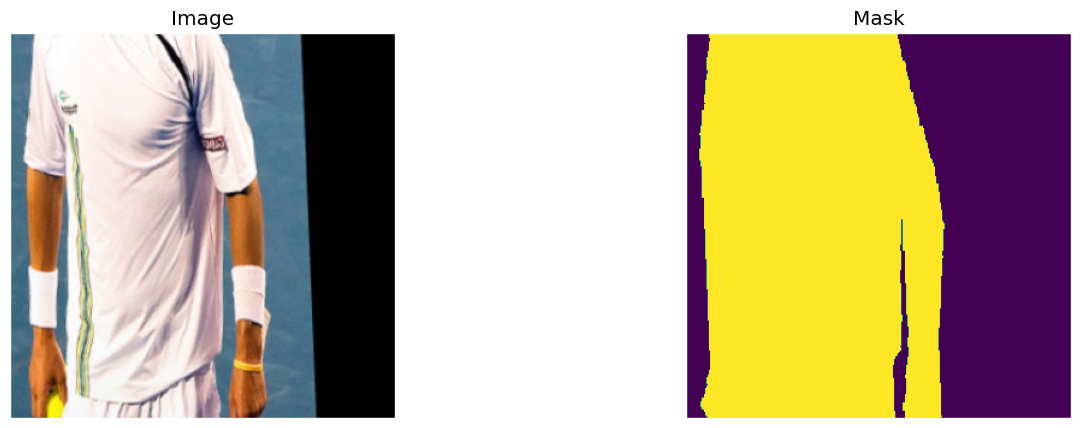

Image and mask for class 0.0


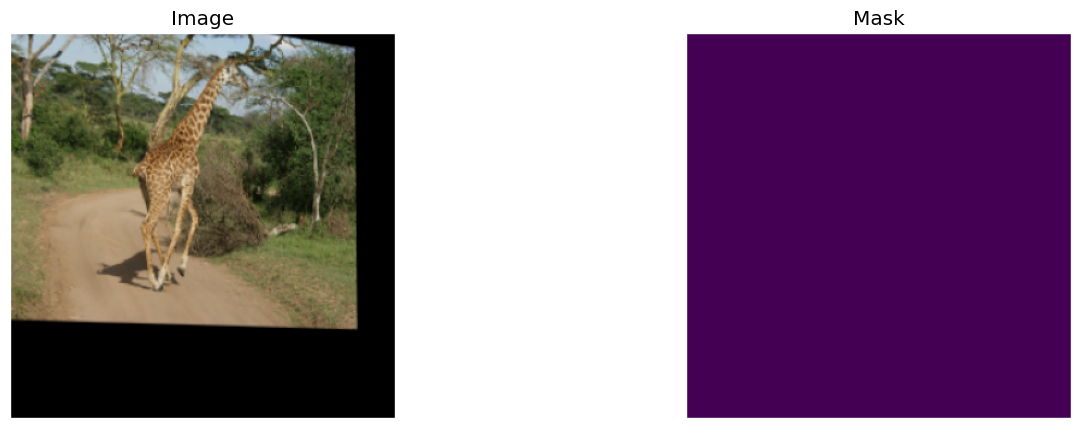

Image and mask for class 0.0


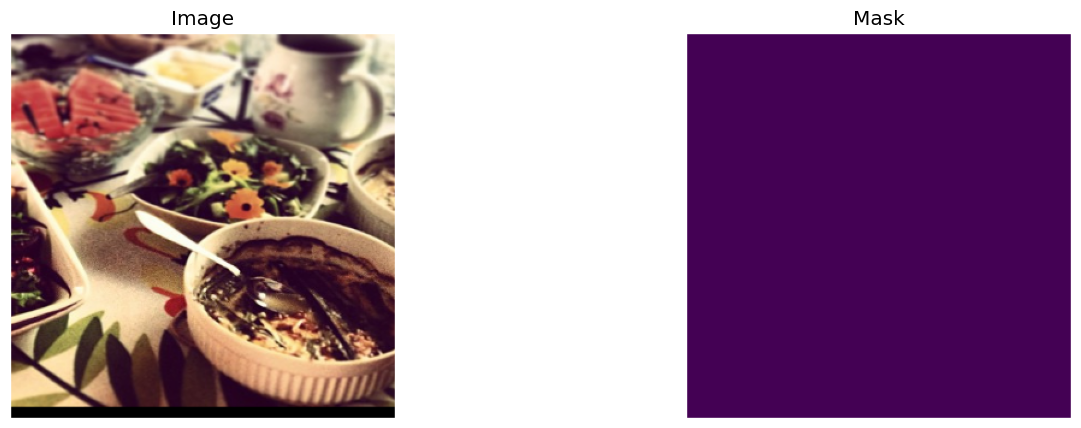

Image and mask for class 0.0


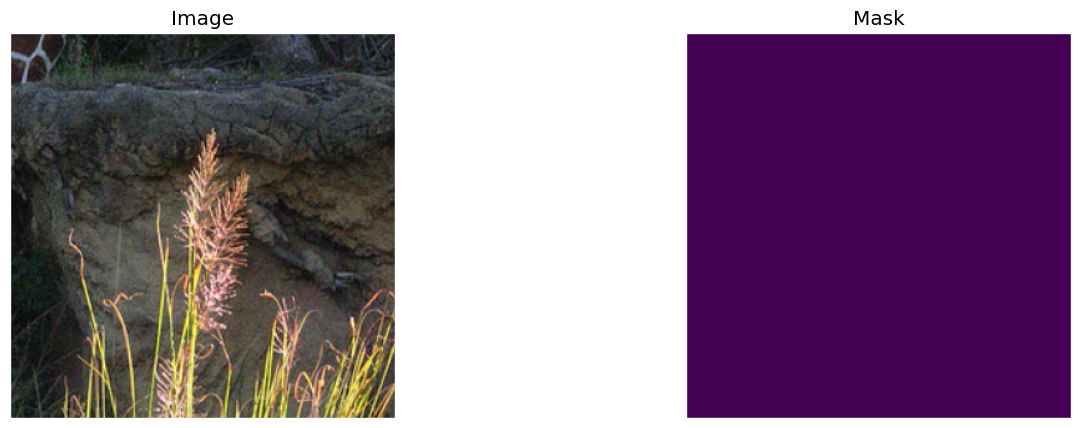

Image and mask for class 1.0


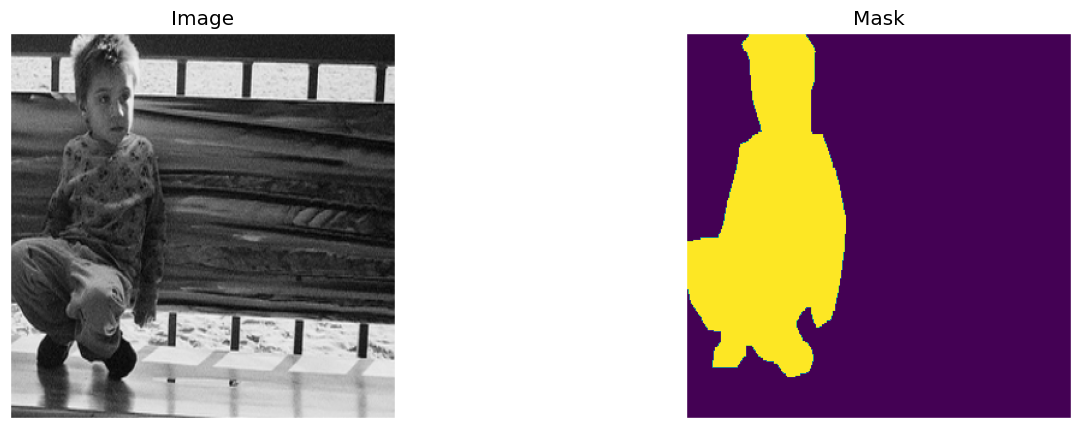

Image and mask for class 1.0


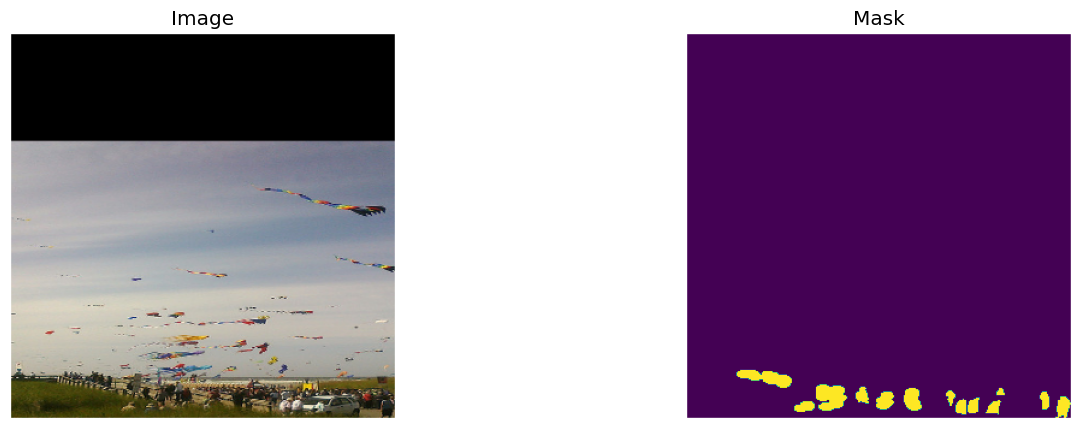

Image and mask for class 1.0


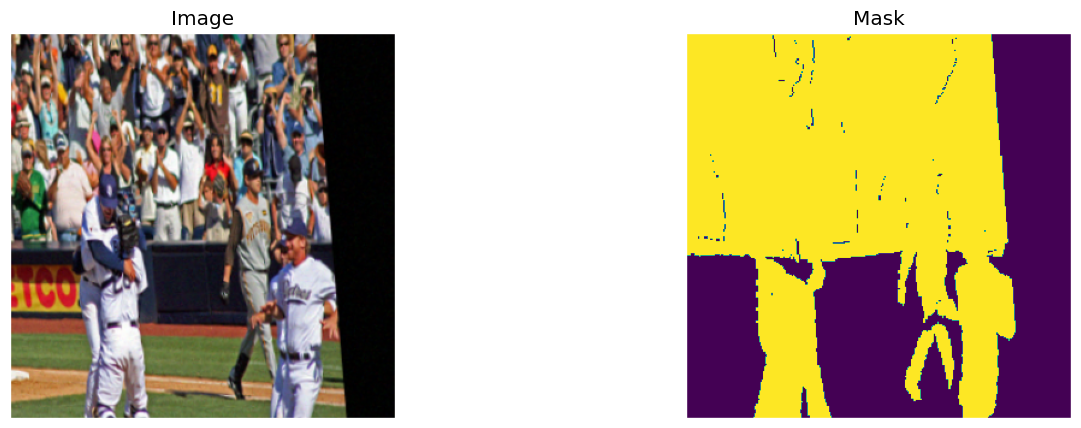

Image and mask for class 0.0


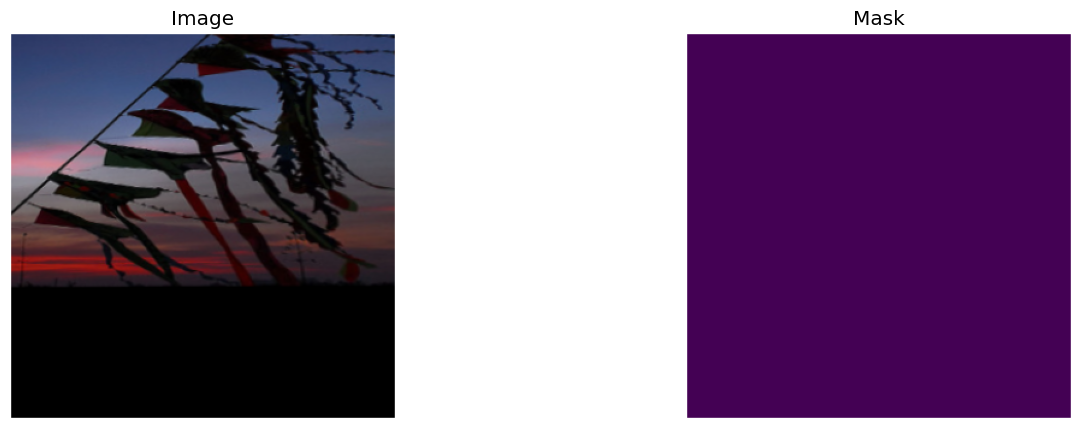

Image and mask for class 1.0


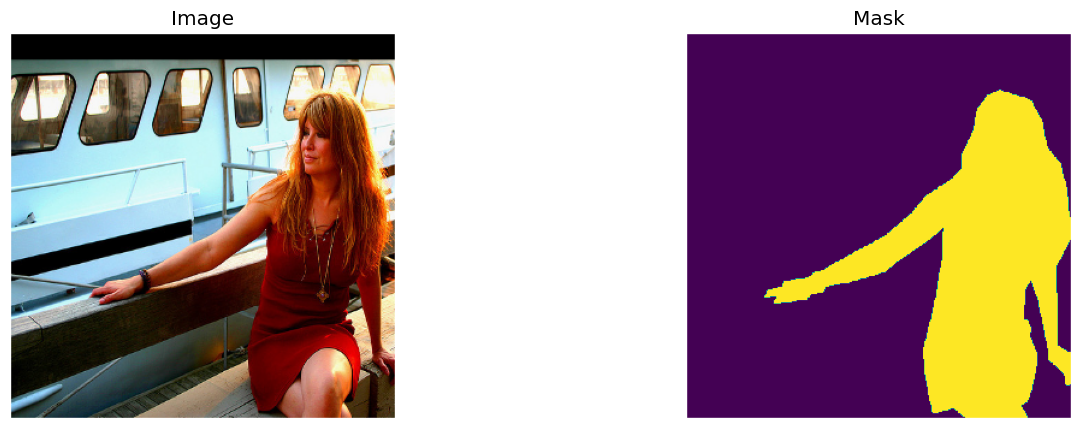

Image and mask for class 1.0


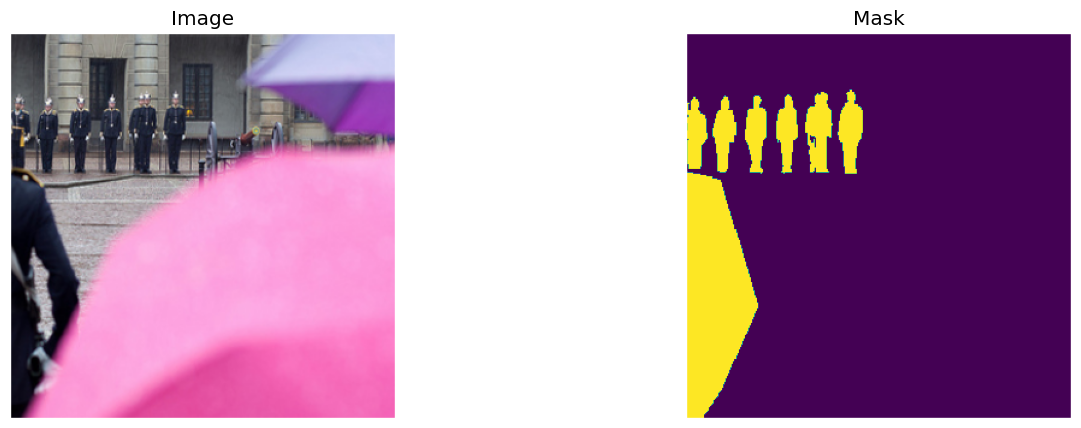

In [172]:
# visual check  work of augmentation
train_dataset = MedPatDataset(
    train_img,
    train_masks,
    preprocessing=None,  # get_preprocessing(preprocessing_fn),
    augmentation=get_training_augmentation(),
)
test_dataset = MedPatDataset(
    test_img,
    test_masks,
    preprocessing=None,
    augmentation=get_training_augmentation(),
)

# same image with different random transforms
for i in range(5):
    image, mask, class_label = train_dataset[i]
    print(f'Image and mask for class {class_label}')
    visualize(image=image, mask=mask.squeeze())

# same image with different random transforms
for i in range(5):
    image, mask, class_label = test_dataset[i]
    print(f'Image and mask for class {class_label}')
    visualize(image=image, mask=mask.squeeze())

# 2. Define and train model

In [173]:
CLASSES = ['human']
ACTIVATION = 'sigmoid'  # could be None for logits or 'softmax2d' for multiclass segmentation

aux_params = dict(
    pooling='avg',  # one of 'avg', 'max'
    dropout=0.5,  # dropout ratio, default is None
    classes=1,  # define number of output labels
    activation=None,
)

# create segmentation model with pretrained encoder
unet = smp.Unet(
    encoder_name=ENCODER,
    encoder_weights=ENCODER_WEIGHTS,
    classes=len(CLASSES),
    aux_params=aux_params,
).to(DEVICE)

In [174]:
unet

Unet(
  (encoder): ResNetEncoder(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track

In [175]:
# architecture of the neural network of the classifier. The output from the encoder is input to this classifier
unet.classification_head

ClassificationHead(
  (0): AdaptiveAvgPool2d(output_size=1)
  (1): Flatten(start_dim=1, end_dim=-1)
  (2): Dropout(p=0.5, inplace=True)
  (3): Linear(in_features=512, out_features=1, bias=True)
  (4): Activation(
    (activation): Identity()
  )
)

In [185]:
INIT_LR = 0.005

# cross_entropy = nn.CrossEntropyLoss()
BCE = nn.BCEWithLogitsLoss()
DICE = smp.losses.DiceLoss(mode='binary')
opt = Adam(unet.parameters(), lr=INIT_LR)


def metrics(y_pred, y_test):
    from sklearn.metrics import accuracy_score, precision_score, recall_score

    return {
        'recall': recall_score(y_test, y_pred),
        'precision': precision_score(y_test, y_pred),
        'accuracy': accuracy_score(y_test, y_pred),
    }


In [186]:
from torch.utils.data import DataLoader

BATCH_SIZE = 16
NUM_EPOCHS = 50

train_dataset = MedPatDataset(
    train_img,
    train_masks,
    preprocessing=get_preprocessing(preprocessing_fn),
    augmentation=get_training_augmentation(),
)
test_dataset = MedPatDataset(
    test_img,
    test_masks,
    preprocessing=get_preprocessing(preprocessing_fn),
    augmentation=get_training_augmentation(),
)


train_loader = DataLoader(
    train_dataset, batch_size=BATCH_SIZE, shuffle=True, pin_memory=PIN_MEMORY
)
test_loader = DataLoader(
    test_dataset, batch_size=BATCH_SIZE, shuffle=False, pin_memory=PIN_MEMORY
)

print('[INFO] training the network...')
# history log
H = {
    'train_loss': [],
    'test_loss': [],
    'recall': [],
    'accuracy': [],
    'precision': [],
}
for e in tqdm(range(NUM_EPOCHS)):
    unet.train()
    # initialize the total training and validation loss
    train_loss = 0
    test_loss = 0
    recall = 0
    accuracy = 0
    precision = 0
    train_steps = 0
    test_steps = 0

    for images, gt_masks, class_label in train_loader:
        train_steps += 1

        (images, gt_masks, class_label) = (
            images.to(DEVICE),
            gt_masks.to(DEVICE),
            class_label.to(DEVICE),
        )
        predicted_mask, labels = unet(images)

        loss = DICE(predicted_mask, gt_masks)
        +BCE(labels, class_label.unsqueeze(1))

        opt.zero_grad()
        loss.backward()
        opt.step()

        train_loss += loss

    # set the model in evaluation mode
    unet.eval()
    # switch off autograd
    with torch.no_grad():
        for images, gt_masks, class_label in test_loader:
            test_steps += 1
            (images, gt_masks, class_label) = (
                images.to(DEVICE),
                gt_masks.to(DEVICE),
                class_label.to(DEVICE),
            )
            predicted_mask, labels = unet(images)

            loss_test = DICE(predicted_mask, gt_masks)
            +BCE(labels, class_label.unsqueeze(1))
            test_loss += loss_test

            # metric calc
            y_pred = (
                torch.sigmoid(labels.view(-1)).cpu().detach().numpy().round()
            )
            y_true = class_label.view(-1).cpu().detach().numpy()
            # print(f'y_pred = {y_pred} y_true = {y_true}')
            batch_metircs = metrics(y_pred, y_true)
            # print(f'batch metrics {batch_metircs}')
            precision += batch_metircs['precision']
            accuracy += batch_metircs['accuracy']
            recall += batch_metircs['recall']

            if e % 10 == 0:
                torch.save(unet, 'unet_medpat.pth')

    # calculate the average training and test loss
    avg_train_loss = train_loss / train_steps
    avg_test_loss = test_loss / test_steps
    avg_recall = recall / test_steps
    avg_precision = precision / test_steps
    avg_accuracy = accuracy / test_steps
    H['train_loss'].append(avg_train_loss.cpu().detach().numpy())
    H['test_loss'].append(avg_test_loss.cpu().detach().numpy())
    H['recall'].append(avg_recall)
    H['precision'].append(avg_precision)
    H['accuracy'].append(avg_accuracy)

    torch.save(unet, 'unet_medpat.pth')

    print(f'[INFO] EPOCH: {e+1}/{NUM_EPOCHS}')
    print(f'Train loss: {avg_train_loss:.6f}, test loss {avg_test_loss:.6f}')
    print(
        f'EPOCH metrics: accuracy {avg_accuracy:.4f}, recall {avg_recall:.4f}, precision {avg_precision:.4f}'
    )


[INFO] training the network...


  2%|▏         | 1/50 [01:47<1:27:49, 107.54s/it]

[INFO] EPOCH: 1/50
Train loss: -0.842303, test loss -0.950723
EPOCH metrics: accuracy 0.5417, recall 1.0000, precision 0.5417


  4%|▍         | 2/50 [03:34<1:25:42, 107.13s/it]

[INFO] EPOCH: 2/50
Train loss: -0.893106, test loss -0.945369
EPOCH metrics: accuracy 0.5417, recall 1.0000, precision 0.5417


  6%|▌         | 3/50 [05:22<1:24:24, 107.75s/it]

[INFO] EPOCH: 3/50
Train loss: -0.898728, test loss -0.949918
EPOCH metrics: accuracy 0.5417, recall 1.0000, precision 0.5417


  8%|▊         | 4/50 [07:09<1:22:23, 107.47s/it]

[INFO] EPOCH: 4/50
Train loss: -0.864338, test loss -0.937274
EPOCH metrics: accuracy 0.5417, recall 1.0000, precision 0.5417


 10%|█         | 5/50 [08:56<1:20:13, 106.97s/it]

[INFO] EPOCH: 5/50
Train loss: -0.888423, test loss -0.947517
EPOCH metrics: accuracy 0.5417, recall 1.0000, precision 0.5417


 12%|█▏        | 6/50 [10:39<1:17:36, 105.84s/it]

[INFO] EPOCH: 6/50
Train loss: -0.828240, test loss -0.948974
EPOCH metrics: accuracy 0.5417, recall 1.0000, precision 0.5417


 14%|█▍        | 7/50 [12:23<1:15:26, 105.27s/it]

[INFO] EPOCH: 7/50
Train loss: -0.868514, test loss -0.931055
EPOCH metrics: accuracy 0.5417, recall 1.0000, precision 0.5417


 16%|█▌        | 8/50 [14:12<1:14:33, 106.51s/it]

[INFO] EPOCH: 8/50
Train loss: -0.865189, test loss -0.949799
EPOCH metrics: accuracy 0.5417, recall 1.0000, precision 0.5417


 18%|█▊        | 9/50 [15:59<1:12:43, 106.42s/it]

[INFO] EPOCH: 9/50
Train loss: -0.889801, test loss -0.948125
EPOCH metrics: accuracy 0.5417, recall 1.0000, precision 0.5417


 20%|██        | 10/50 [17:45<1:10:54, 106.37s/it]

[INFO] EPOCH: 10/50
Train loss: -0.865677, test loss -0.946649
EPOCH metrics: accuracy 0.5417, recall 1.0000, precision 0.5417


 22%|██▏       | 11/50 [19:32<1:09:19, 106.66s/it]

[INFO] EPOCH: 11/50
Train loss: -0.890307, test loss -0.945049
EPOCH metrics: accuracy 0.5417, recall 1.0000, precision 0.5417


 24%|██▍       | 12/50 [21:19<1:07:34, 106.68s/it]

[INFO] EPOCH: 12/50
Train loss: -0.896725, test loss -0.952345
EPOCH metrics: accuracy 0.5417, recall 1.0000, precision 0.5417


 26%|██▌       | 13/50 [23:05<1:05:42, 106.55s/it]

[INFO] EPOCH: 13/50
Train loss: -0.740896, test loss -0.947848
EPOCH metrics: accuracy 0.5417, recall 1.0000, precision 0.5417


 28%|██▊       | 14/50 [24:51<1:03:53, 106.47s/it]

[INFO] EPOCH: 14/50
Train loss: -0.882679, test loss -0.950204
EPOCH metrics: accuracy 0.5417, recall 1.0000, precision 0.5417


 30%|███       | 15/50 [26:38<1:02:04, 106.41s/it]

[INFO] EPOCH: 15/50
Train loss: -0.885755, test loss -0.942658
EPOCH metrics: accuracy 0.5417, recall 1.0000, precision 0.5417


 32%|███▏      | 16/50 [28:24<1:00:15, 106.35s/it]

[INFO] EPOCH: 16/50
Train loss: -0.890003, test loss -0.943032
EPOCH metrics: accuracy 0.5417, recall 1.0000, precision 0.5417


 34%|███▍      | 17/50 [30:10<58:24, 106.19s/it]  

[INFO] EPOCH: 17/50
Train loss: -0.881679, test loss -0.943144
EPOCH metrics: accuracy 0.5417, recall 1.0000, precision 0.5417


 36%|███▌      | 18/50 [31:56<56:38, 106.20s/it]

[INFO] EPOCH: 18/50
Train loss: -0.878625, test loss -0.952175
EPOCH metrics: accuracy 0.5417, recall 1.0000, precision 0.5417


 38%|███▊      | 19/50 [33:42<54:53, 106.25s/it]

[INFO] EPOCH: 19/50
Train loss: -0.877693, test loss -0.950707
EPOCH metrics: accuracy 0.5417, recall 1.0000, precision 0.5417


 40%|████      | 20/50 [35:29<53:07, 106.24s/it]

[INFO] EPOCH: 20/50
Train loss: -0.821788, test loss -0.952186
EPOCH metrics: accuracy 0.5417, recall 1.0000, precision 0.5417


 42%|████▏     | 21/50 [37:15<51:22, 106.28s/it]

[INFO] EPOCH: 21/50
Train loss: -0.876442, test loss -0.945006
EPOCH metrics: accuracy 0.5417, recall 1.0000, precision 0.5417


 44%|████▍     | 22/50 [39:01<49:33, 106.21s/it]

[INFO] EPOCH: 22/50
Train loss: -0.893406, test loss -0.945296
EPOCH metrics: accuracy 0.5417, recall 1.0000, precision 0.5417


 46%|████▌     | 23/50 [40:47<47:47, 106.21s/it]

[INFO] EPOCH: 23/50
Train loss: -0.897596, test loss -0.952709
EPOCH metrics: accuracy 0.5417, recall 1.0000, precision 0.5417


 48%|████▊     | 24/50 [42:33<46:00, 106.16s/it]

[INFO] EPOCH: 24/50
Train loss: -0.882693, test loss -0.946055
EPOCH metrics: accuracy 0.5417, recall 1.0000, precision 0.5417


 50%|█████     | 25/50 [44:20<44:16, 106.25s/it]

[INFO] EPOCH: 25/50
Train loss: -0.909226, test loss -0.935899
EPOCH metrics: accuracy 0.5417, recall 1.0000, precision 0.5417


 52%|█████▏    | 26/50 [46:06<42:29, 106.21s/it]

[INFO] EPOCH: 26/50
Train loss: -0.878486, test loss -0.938195
EPOCH metrics: accuracy 0.5417, recall 1.0000, precision 0.5417


 54%|█████▍    | 27/50 [47:52<40:42, 106.19s/it]

[INFO] EPOCH: 27/50
Train loss: -0.875342, test loss -0.947406
EPOCH metrics: accuracy 0.5417, recall 1.0000, precision 0.5417


 56%|█████▌    | 28/50 [49:38<38:54, 106.12s/it]

[INFO] EPOCH: 28/50
Train loss: -0.896927, test loss -0.946603
EPOCH metrics: accuracy 0.5417, recall 1.0000, precision 0.5417


 58%|█████▊    | 29/50 [51:24<37:08, 106.12s/it]

[INFO] EPOCH: 29/50
Train loss: -0.889938, test loss -0.939434
EPOCH metrics: accuracy 0.5417, recall 1.0000, precision 0.5417


 60%|██████    | 30/50 [53:10<35:24, 106.21s/it]

[INFO] EPOCH: 30/50
Train loss: -0.824177, test loss -0.946337
EPOCH metrics: accuracy 0.5417, recall 1.0000, precision 0.5417


 62%|██████▏   | 31/50 [54:59<33:50, 106.89s/it]

[INFO] EPOCH: 31/50
Train loss: -0.885119, test loss -0.935434
EPOCH metrics: accuracy 0.5417, recall 1.0000, precision 0.5417


 64%|██████▍   | 32/50 [56:48<32:13, 107.39s/it]

[INFO] EPOCH: 32/50
Train loss: -0.873215, test loss -0.946315
EPOCH metrics: accuracy 0.5417, recall 1.0000, precision 0.5417


 66%|██████▌   | 33/50 [58:33<30:17, 106.91s/it]

[INFO] EPOCH: 33/50
Train loss: -0.880589, test loss -0.952381
EPOCH metrics: accuracy 0.5417, recall 1.0000, precision 0.5417


 68%|██████▊   | 34/50 [1:00:19<28:26, 106.64s/it]

[INFO] EPOCH: 34/50
Train loss: -0.879036, test loss -0.954228
EPOCH metrics: accuracy 0.5417, recall 1.0000, precision 0.5417


 70%|███████   | 35/50 [1:02:02<26:22, 105.50s/it]

[INFO] EPOCH: 35/50
Train loss: -0.897937, test loss -0.941066
EPOCH metrics: accuracy 0.5417, recall 1.0000, precision 0.5417


 72%|███████▏  | 36/50 [1:03:45<24:24, 104.61s/it]

[INFO] EPOCH: 36/50
Train loss: -0.858222, test loss -0.949864
EPOCH metrics: accuracy 0.5417, recall 1.0000, precision 0.5417


 74%|███████▍  | 37/50 [1:05:27<22:31, 103.99s/it]

[INFO] EPOCH: 37/50
Train loss: -0.889268, test loss -0.947308
EPOCH metrics: accuracy 0.5417, recall 1.0000, precision 0.5417


 76%|███████▌  | 38/50 [1:07:10<20:42, 103.55s/it]

[INFO] EPOCH: 38/50
Train loss: -0.829904, test loss -0.945598
EPOCH metrics: accuracy 0.5417, recall 1.0000, precision 0.5417


 78%|███████▊  | 39/50 [1:08:52<18:55, 103.22s/it]

[INFO] EPOCH: 39/50
Train loss: -0.885996, test loss -0.942471
EPOCH metrics: accuracy 0.5417, recall 1.0000, precision 0.5417


 80%|████████  | 40/50 [1:10:35<17:10, 103.05s/it]

[INFO] EPOCH: 40/50
Train loss: -0.874431, test loss -0.947289
EPOCH metrics: accuracy 0.5417, recall 1.0000, precision 0.5417


 82%|████████▏ | 41/50 [1:12:18<15:27, 103.04s/it]

[INFO] EPOCH: 41/50
Train loss: -0.863282, test loss -0.947367
EPOCH metrics: accuracy 0.5417, recall 1.0000, precision 0.5417


 84%|████████▍ | 42/50 [1:14:01<13:43, 102.92s/it]

[INFO] EPOCH: 42/50
Train loss: -0.881606, test loss -0.950407
EPOCH metrics: accuracy 0.5417, recall 1.0000, precision 0.5417


 86%|████████▌ | 43/50 [1:15:43<12:00, 102.92s/it]

[INFO] EPOCH: 43/50
Train loss: -0.884034, test loss -0.938543
EPOCH metrics: accuracy 0.5417, recall 1.0000, precision 0.5417


 88%|████████▊ | 44/50 [1:17:26<10:17, 102.94s/it]

[INFO] EPOCH: 44/50
Train loss: -0.894856, test loss -0.944384
EPOCH metrics: accuracy 0.5417, recall 1.0000, precision 0.5417


 90%|█████████ | 45/50 [1:19:09<08:34, 102.94s/it]

[INFO] EPOCH: 45/50
Train loss: -0.861983, test loss -0.944761
EPOCH metrics: accuracy 0.5417, recall 1.0000, precision 0.5417


 92%|█████████▏| 46/50 [1:20:54<06:53, 103.47s/it]

[INFO] EPOCH: 46/50
Train loss: -0.843378, test loss -0.951502
EPOCH metrics: accuracy 0.5417, recall 1.0000, precision 0.5417


 94%|█████████▍| 47/50 [1:22:37<05:09, 103.32s/it]

[INFO] EPOCH: 47/50
Train loss: -0.876534, test loss -0.946382
EPOCH metrics: accuracy 0.5417, recall 1.0000, precision 0.5417


 96%|█████████▌| 48/50 [1:24:20<03:26, 103.16s/it]

[INFO] EPOCH: 48/50
Train loss: -0.874601, test loss -0.948480
EPOCH metrics: accuracy 0.5417, recall 1.0000, precision 0.5417


 98%|█████████▊| 49/50 [1:26:03<01:43, 103.13s/it]

[INFO] EPOCH: 49/50
Train loss: -0.877799, test loss -0.944546
EPOCH metrics: accuracy 0.5417, recall 1.0000, precision 0.5417


100%|██████████| 50/50 [1:27:46<00:00, 105.33s/it]

[INFO] EPOCH: 50/50
Train loss: -0.888647, test loss -0.939045
EPOCH metrics: accuracy 0.5417, recall 1.0000, precision 0.5417


# 3. Plots grapths loss function and metrisc

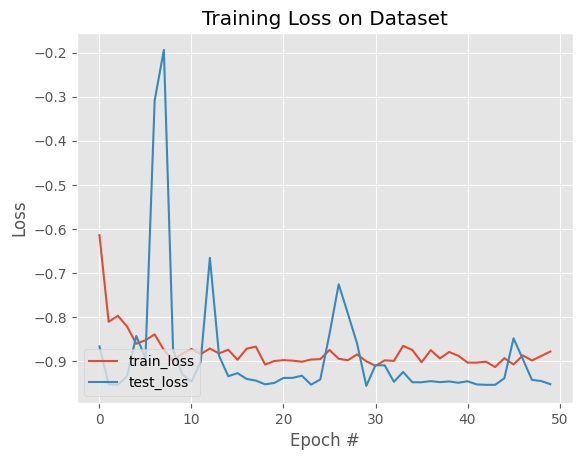

In [184]:
# plot the training/test loss
plt.style.use('ggplot')
plt.figure()
plt.plot(H['train_loss'], label='train_loss')
plt.plot(H['test_loss'], label='test_loss')
plt.title('Training Loss on Dataset')
plt.xlabel('Epoch #')
plt.ylabel('Loss')
plt.legend(loc='lower left')


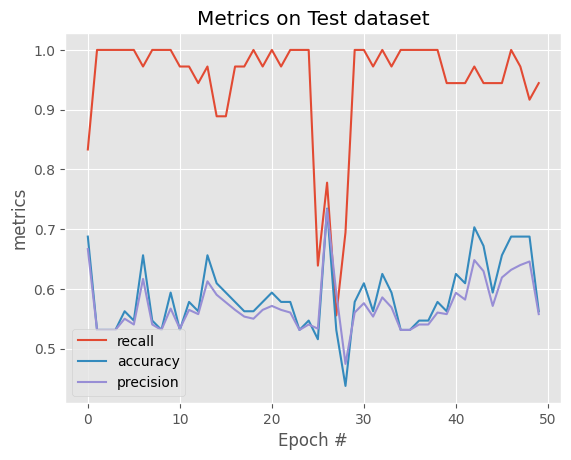

In [180]:
# plot the metrics
plt.style.use('ggplot')
plt.figure()
plt.plot(H['recall'], label='recall')
plt.plot(H['accuracy'], label='accuracy')
plt.plot(H['precision'], label='precision')
plt.title('Metrics on Test dataset')
plt.xlabel('Epoch #')
plt.ylabel('metrics')
plt.legend(loc='lower left')

# 4. Visualize predictions

In [181]:
def classify_image(path_image, path_model):
    import cv2
    import matplotlib.pyplot as plt
    import numpy as np
    import torch

    image_initial = cv2.imread(path_image)
    image = cv2.cvtColor(image_initial, cv2.COLOR_BGR2RGB)
    image = cv2.resize(image, (320, 320))
    image = np.transpose(image, (2, 0, 1)).astype('float32')
    image = np.expand_dims(image, 0)
    image = torch.from_numpy(image)

    mask_real = cv2.imread(
        path_image.replace('images', 'masks').replace('jpg', 'png'), 0
    )
    class_label = int((np.sum(mask_real) > 0))

    unet = torch.load(path_model).cpu()
    unet.eval()
    # switch off autograd
    with torch.no_grad():
        predicted_mask, pred_label = unet(image)
        predicted_mask = predicted_mask.squeeze()
        predicted_mask = torch.sigmoid(predicted_mask)
        predicted_mask = predicted_mask.numpy()
        # filter out the weak predictions and convert them to integers
        predicted_mask = predicted_mask.round()
        predicted_mask = predicted_mask.astype(np.uint8)
        predicted_mask = np.expand_dims(predicted_mask, 0)
        pred_label = int(torch.sigmoid(pred_label).round())

    # prepare a plot for visualization
    pred_label = -1
    print(f'Prediction class {pred_label} - real class {class_label}')
    plt.figure(figsize=(16, 5))
    # image
    plt.subplot(1, 3, 1)
    plt.xticks([])
    plt.yticks([])
    plt.title('Image')
    plt.imshow(image_initial)
    # real mask
    plt.subplot(1, 3, 2)
    plt.xticks([])
    plt.yticks([])
    plt.title('Real mask')
    plt.imshow(mask_real)
    # predicted mask
    plt.subplot(1, 3, 3)
    plt.xticks([])
    plt.yticks([])
    plt.title('Predicted mask')
    plt.imshow(predicted_mask[0])
    plt.show()

C:\Users\demko_r\AppData\Local\Temp\ipykernel_12496\3342670666.py:19: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  unet = torch.load(path_model).cpu()


Prediction class -1 - real class 0


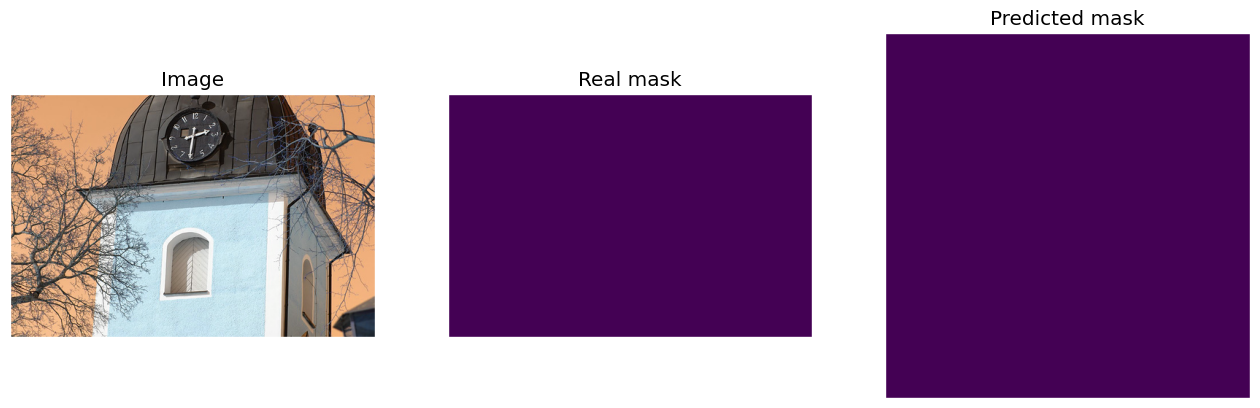

Prediction class -1 - real class 1


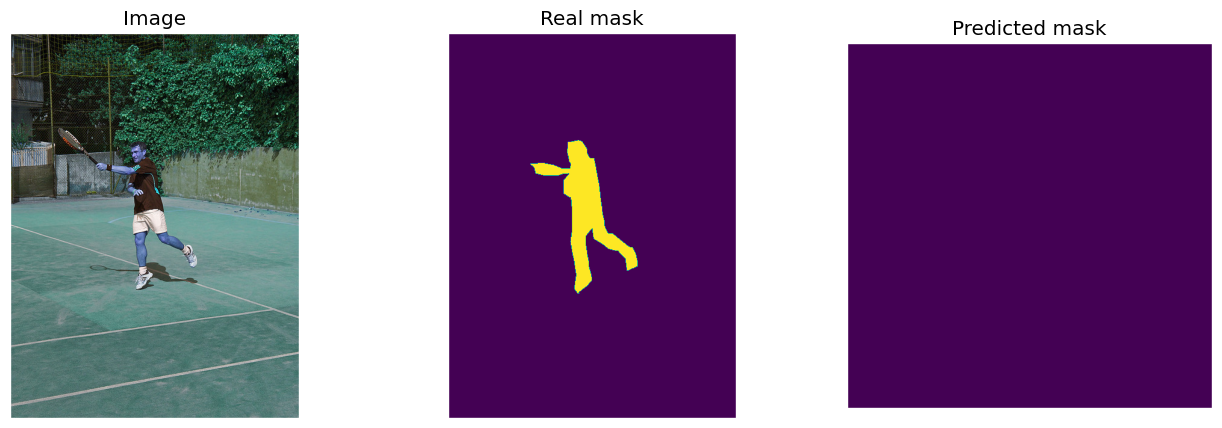

In [182]:
# no human
classify_image(
    path_image=os.path.join(DATA_DIR, 'images', '000000009509.jpg'),
    path_model='unet_medpat.pth',
)

# human
classify_image(
    path_image=os.path.join(DATA_DIR, 'images', '000000545525.jpg'),
    path_model='unet_medpat.pth',
)

C:\Users\demko_r\AppData\Local\Temp\ipykernel_12496\3342670666.py:19: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  unet = torch.load(path_model).cpu()


Prediction class -1 - real class 1


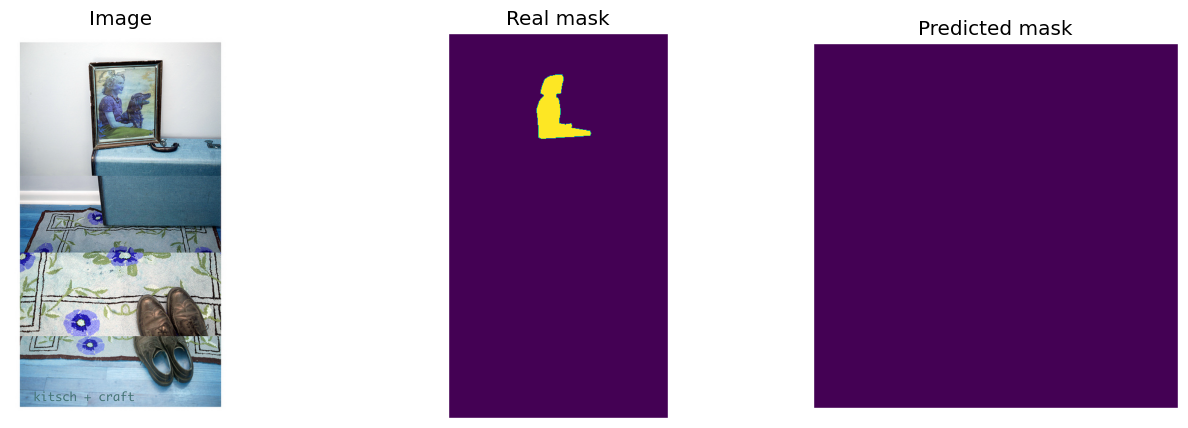

In [183]:
classify_image(
    path_image=os.path.join(DATA_DIR, 'images', '000000535650.jpg'),
    path_model='unet_medpat.pth',
)